In [1]:
import matplotlib.pyplot as plt
import numpy as np

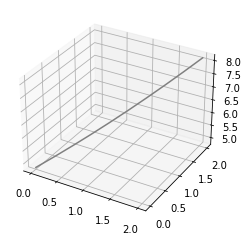

In [31]:
fig = plt.figure()
ax1 = plt.axes(projection='3d')
F0 = np.linspace(0,2,10)
F1 = np.linspace(0,2,10)
X0 = 24/5+2/3*F0+11/15*F1+5/36*F0*F1

ax1.plot3D(F0,F1,X0,'gray')   
plt.show()


In [32]:
x,y = 0,0
24/5+2/3*x+11/15*y+5/36*x*y

4.8